### Exploring our financial dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data

In [2]:
import yfinance as yf
yf.pdr_override()

In [3]:
def load_financial_data(start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        # df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
        df = data.get_data_yahoo('GOOG', start=start_date, end=end_date)
        df.to_pickle(output_file)
    return df

In [4]:
def create_classification_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)
    return (df, X, Y)

In [5]:
def create_regression_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df['Target'] = df['Close'].shift(-1) - df['Close']
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = df[['Target']]
    return (df, X, Y)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
def create_train_split_group(X, Y, shuffle=False, split_ratio=0.8):
    return train_test_split(X, Y, shuffle=shuffle, train_size=split_ratio)

### Ordinary Least Squares

1. Let's start by loading up Google data in the code, using the same method that we introduced in the previous section:

In [8]:
goog_data = load_financial_data(
    start_date='2001-01-01',
    end_date='2018-01-01',
    output_file='goog_data_large.pkl')

File data found...reading GOOG data


2. Now, we create and populate the target variable vector, Y, for regression in the following code. Remember that what we are trying to predict in regression is magnitude and the direction of the price change from one day to the next:

In [9]:
goog_data, X, Y = create_regression_trading_condition(goog_data)

3. With the help of the code, let's quickly create a scatter plot for the two features we have: High-Low price of the day and Open-Close price of the day against the target variable, which is Price-Of-Next-Day - Price-Of-Today (future price):

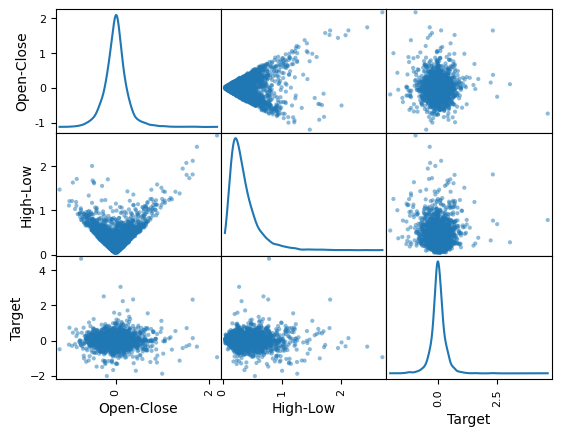

In [10]:
pd.plotting.scatter_matrix(goog_data[['Open-Close', 'High-Low', 'Target']], grid=True, diagonal='kde', alpha=0.5)
plt.show()

4. Finally, as shown in the code, let's split 80% of the available data into the training feature value and target variable set (X_train, Y_train), and the remaining 20% of the dataset into the out-sample testing feature value and target variable set (X_test, Y_test):

In [11]:
X_train, X_test, Y_train, Y_test = create_train_split_group(X, Y, split_ratio=0.8)

5. Now, let's fit the OLS model as shown here and observe the model we obtain:

In [12]:
from sklearn import linear_model

ols = linear_model.LinearRegression()
ols.fit(X_train, Y_train)

LinearRegression()

6. The coefficients are the optimal weights assigned to the two features by the fit method. We will print the coefficients as shown in the code:

In [13]:
print('Coefficients: \n', ols.coef_)

Coefficients: 
 [[ 0.02410153 -0.05781455]]


7. The next block of code quantifies two very common metrics that test goodness of fit for the linear model we just built. Goodness of fit means how well a given model fits the data points observed in training and testing data. A good model is able to closely fit most of the data points and errors/deviations between observed and predicted values are very low. 
    
    Two of the most popular metrics for linear regression models are `mean_squared_error` $‖X•W-y‖_2^2$, which is what we explored as our objective to minimize when we introduced OLS, and R-squared ($R^2$), which is another very popular metric that measures how well the fitted model predicts the target variable when compared to a baseline model whose prediction output is always the mean of the target variable based on training data, that is, $\hat{y}=\frac{\sum_{i=1}^ny_i}{n}$.
    
    We will skip the exact formulas for computing $R^2$ but, intuitively, the closer the $R^2$ value to 1, the better the fit, and the closer $R^2$ the value to 0, the worse the fit. Negative $R^2$ values mean that the model fits worse than the baseline model. Models with negative values usually indicate issues in the training data or process and cannot be used:

In [14]:
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_train, ols.predict(X_train)))

Mean squared error: 0.07


In [16]:
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_train, ols.predict(X_train)))

Variance score: 0.00


In [17]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, ols.predict(X_test)))

Mean squared error: 0.26


In [18]:
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, ols.predict(X_test)))

Variance score: -0.01


8. Finally, as shown in the code, let's use it to predict prices and calculate strategy returns:

In [19]:
goog_data['Predicted_Signal'] = ols.predict(X)
goog_data['GOOG_Returns'] = np.log(goog_data['Close'] / goog_data['Close'].shift(1))
goog_data.head()

,Open,High,Low,Close,Adj Close,Volume,Open-Close,High-Low,Target,Predicted_Signal,GOOG_Returns
Date,,,,,,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216,-0.008469,0.201743,0.198506,0.014064,NaN
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488,-0.181819,0.213699,0.027148,0.009194,0.076433
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939,0.033624,0.110336,-0.112827,0.020363,0.010013
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159,0.158655,0.200000,0.028144,0.018192,-0.042289
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512,-0.025903,0.102616,0.047572,0.019374,0.010717


In [20]:
def calculate_return(df, split_value, symbol):
    cum_goog_return = df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns'] = df['%s_Returns' %
                                symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return


def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

In [21]:
cum_goog_return = calculate_return(
    goog_data, split_value=len(X_train), symbol='GOOG')
cum_strategy_return = calculate_strategy_return(
    goog_data, split_value=len(X_train), symbol='GOOG')

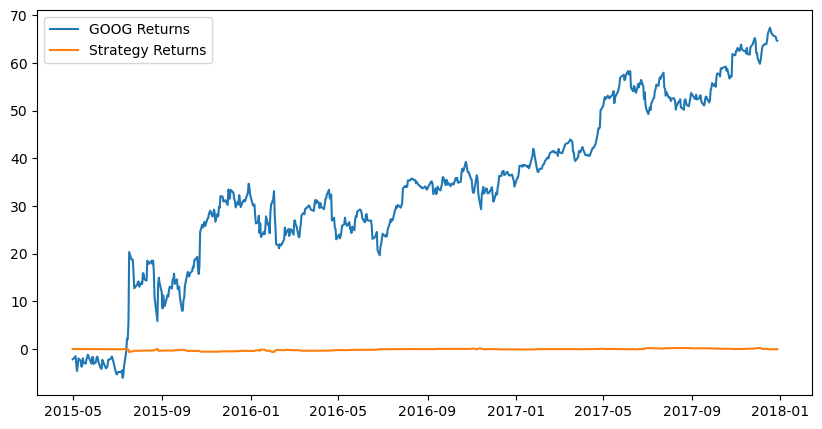

In [22]:
def plot_chart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.legend()
    plt.show()

plot_chart(cum_goog_return, cum_strategy_return, symbol='GOOG')

In [23]:
def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()

sharpe_ratio(cum_goog_return, cum_strategy_return)

-174.96138800535732

### Regularization and shrinkage – LASSO and Ridge regression

Let's apply Lasso regression to our dataset and inspect the coefficients in the following code. With a regularization parameter of 0.1, we see that the first predictor gets assigned a coefficient that is roughly half of what was assigned by OLS:

In [24]:
from sklearn import linear_model

# Fit the model
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train, Y_train)

Lasso(alpha=0.1)

In [25]:
# The coefficients
print('Coefficients: \n', lasso.coef_)

Coefficients: 
 [ 0. -0.]


Now, let's apply Ridge regression to our dataset and observe the coefficients:

In [26]:
from sklearn import linear_model

# Fit the model
ridge = linear_model.Ridge(alpha=10000)
ridge.fit(X_train, Y_train)

Ridge(alpha=10000)

In [27]:
print('Coefficients: \n', ridge.coef_)

Coefficients: 
 [[ 0.000168   -0.00045248]]


### K-nearest neighbors

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

1. Let's get the Google data from January 1, 2001 to January 1, 2018:

In [29]:
goog_data=load_financial_data(start_date='2001-01-01',
                              end_date = '2018-01-01',
                              output_file='goog_data_large.pkl')

File data found...reading GOOG data


2. We create the rule when the strategy will take a long position (+1) and a short position (-1), as shown in the following code:

In [30]:
def create_trading_condition(df):
    df['Open-Close']=df.Open-df.Close
    df['High-Low']=df.High-df.Low
    df=df.dropna()
    X=df[['Open-Close','High-Low']]
    Y=np.where(df['Close'].shift(-1)>df['Close'],1,-1)
    return (X,Y)

In [31]:
X, Y = create_trading_condition(goog_data)

3. We prepare the training and testing dataset as shown in the following code:

In [32]:
X_train, X_test, Y_train, Y_test = create_train_split_group(X, Y, split_ratio=0.8)

4. In this example, we choose a KNN with K=15. We will train this model using the training dataset as shown in the following code:

In [33]:
knn=KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=15)

In [34]:
accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_train

0.6144130757800892

In [35]:
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))
accuracy_test

0.5

5. Once the model is created, we are going to predict whether the price goes up or down and store the values in the original data frame, as shown in the following code:

In [36]:
goog_data['Predicted_Signal'] = knn.predict(X)

6. In order to compare the strategy using the KNN algorithm, we will use the return of the GOOG symbol without d, as shown in the following code:

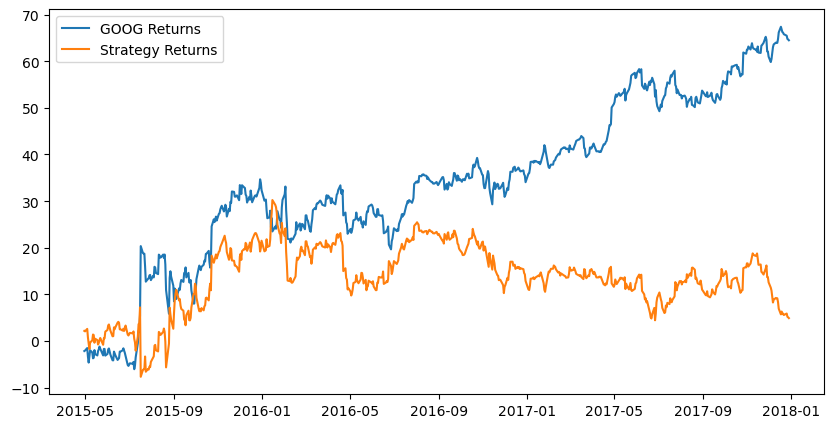

In [37]:
goog_data['GOOG_Returns']=np.log(goog_data['Close']/
                                 goog_data['Close'].shift(1))

cum_goog_return=calculate_return(goog_data, split_value=len(X_train), symbol='GOOG')
cum_strategy_return= calculate_strategy_return(goog_data, split_value=len(X_train), symbol='GOOG')

plot_chart(cum_goog_return, cum_strategy_return,symbol='GOOG')

In [38]:
sharpe_ratio(cum_goog_return, cum_strategy_return)

-2.9248586573441324

### Support vector machine

In [39]:
from sklearn.svm import SVC

In [40]:
# Fit the model
svc = SVC()
svc.fit(X_train, Y_train)

SVC()

In [41]:
accuracy_train = accuracy_score(Y_train, svc.predict(X_train))
accuracy_train

0.5427191679049034

In [42]:
accuracy_test = accuracy_score(Y_test, svc.predict(X_test))
accuracy_test

0.4821958456973294

In [43]:
# Forecast value
goog_data['Predicted_Signal']=svc.predict(X)
goog_data['GOOG_Returns']=np.log(goog_data['Close']/
                                 goog_data['Close'].shift(1))

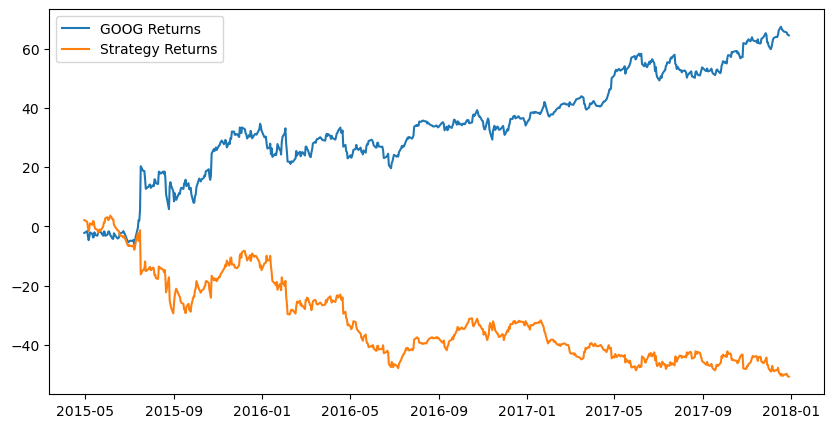

In [44]:
cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol='GOOG')
cum_strategy_return= calculate_strategy_return(goog_data,split_value=len(X_train),symbol='GOOG')

plot_chart(cum_goog_return, cum_strategy_return,symbol='GOOG')

In [45]:
sharpe_ratio(cum_goog_return, cum_strategy_return)

-4.653322433447471

### Logistic regression

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
logistic=LogisticRegression()
logistic.fit(X_train, Y_train)

LogisticRegression()

In [48]:
accuracy_train = accuracy_score(Y_train, logistic.predict(X_train))
accuracy_train

0.5096582466567607

In [49]:
accuracy_test = accuracy_score(Y_test, logistic.predict(X_test))
accuracy_test

0.5356083086053413

In [50]:
goog_data['Predicted_Signal']=logistic.predict(X)
goog_data['GOOG_Returns']=np.log(goog_data['Close']/goog_data['Close'].shift(1))

In [51]:
cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol='GOOG')
cum_strategy_return= calculate_strategy_return(goog_data,split_value=len(X_train),symbol='GOOG')

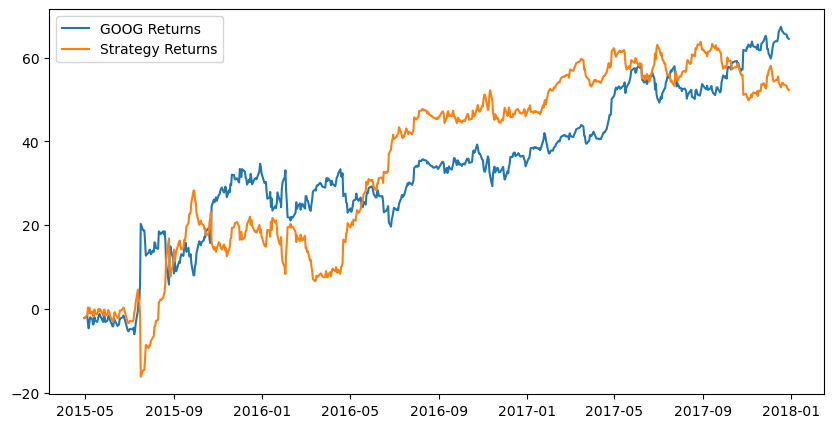

In [52]:
plot_chart(cum_goog_return, cum_strategy_return,symbol='GOOG')

In [53]:
sharpe_ratio(cum_goog_return, cum_strategy_return)

0.0659866691808583